In [1]:
import os
import cv2
import pandas as pd
import math
import numpy as np
import warnings
warnings.filterwarnings("ignore")

PIXELS = 1024
DIMENSIONS = np.int16(math.sqrt(PIXELS))

TRAINING_FEATURES_FILE = "csvTrainImages 13440x1024.csv"
TRAINING_LABELS_FILE = "csvTrainLabel 13440x1.csv"
TESTING_FEATURES_FILE = "csvTestImages 3360x1024.csv"
TESTING_LABELS_FILE = "csvTestLabel 3360x1.csv"

MODEL_NAME = "trained_model.h5"

PCA_THRESHOLD = 0.9

def load_data(file=TRAINING_FEATURES_FILE, header=True):
    csv_path = os.path.join("dataset/", file)
    if header:
        return pd.read_csv(csv_path)
    else:
        return pd.read_csv(csv_path, header=None)

In [2]:
data = load_data(TRAINING_FEATURES_FILE)
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.896,0.897,0.898,0.899,0.900,0.901,0.902,0.903,0.904,0.905
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from matplotlib import pyplot as plt

def imagify(arr, getimage=False, showimage=True):
    img = np.array(np.reshape(arr, (DIMENSIONS, DIMENSIONS)), dtype="uint8")
    if showimage:
        plt.imshow(img, interpolation='nearest')
        plt.gray()
        plt.show() 
        
    if getimage:
        return img

In [4]:
def showimage(img):
    plt.imshow(img, interpolation='nearest')
    plt.gray()
    plt.show() 

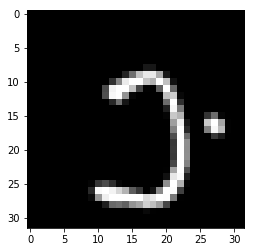

In [5]:
img = imagify(data.values[7], getimage=True)

In [6]:
th1,img1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

127.0


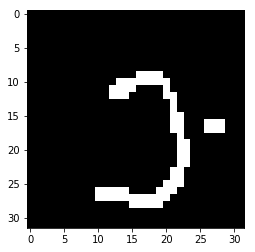

In [7]:
print(th1)
showimage(img1)

In [8]:
th2,img2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

102.0


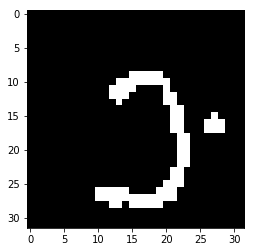

In [9]:
print(th2)
showimage(img2)

In [10]:
blur = cv2.GaussianBlur(img,(5,5),0)
th3,img3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

58.0


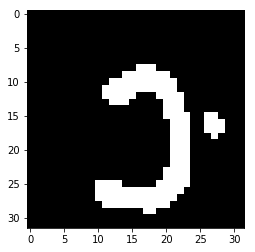

In [11]:
print(th3)
showimage(img3)

In [12]:
THRESH_BINARY = cv2.THRESH_BINARY
THRESH_BINARY_AND_THRESH_OTSU = cv2.THRESH_BINARY+cv2.THRESH_OTSU

In [13]:
def apply_thresholding(df, cap=0, thres=THRESH_BINARY_AND_THRESH_OTSU):
    if thres == None:
        return df
    
    values = df.values
    thres_values = []
    thresholding_started = False
    for value in values:
        img = imagify(value, getimage=True, showimage=False)
        th_,img = cv2.threshold(img,cap,255,thres)
        img = [img.flatten()]
        if thresholding_started:
            thres_values = np.concatenate((thres_values, img), axis=0)
        else:
            thres_values = img
            thresholding_started = True
            
    thres_df = pd.DataFrame(thres_values, columns=df.columns)
    return thres_df

In [14]:
datacopy = data.copy()
data = apply_thresholding(data, thres=THRESH_BINARY_AND_THRESH_OTSU)
data.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.896,0.897,0.898,0.899,0.900,0.901,0.902,0.903,0.904,0.905
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
training_features = data.copy()

In [16]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")
imputer.fit(training_features)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [17]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(training_features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
from sklearn.decomposition import PCA

In [19]:
training_features = imputer.transform(training_features)
training_features = scalar.transform(training_features)

In [20]:
data_labels = load_data(TRAINING_LABELS_FILE)
training_labels = data_labels.values.flatten()

In [21]:
test_data = load_data(TESTING_FEATURES_FILE)
test_data = apply_thresholding(test_data, thres=THRESH_BINARY_AND_THRESH_OTSU)
testing_features = test_data.copy()
testing_features = imputer.transform(testing_features)
testing_features = scalar.transform(testing_features)

In [22]:
test_data_labels = load_data(TESTING_LABELS_FILE)
testing_labels = test_data_labels.values.flatten()

In [23]:
# SGD Classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

pca = PCA(n_components=PCA_THRESHOLD)
pca.fit(training_features)
train_x = pca.transform(training_features)
test_x = pca.transform(testing_features)

sgd_clf = SGDClassifier(random_state=42)
print("Cross Val Scores on training set\n", cross_val_score(clone(sgd_clf), train_x, training_labels, cv=3, scoring="accuracy"))


sgd_clf.fit(train_x, training_labels)
print("\n\nAccuracy on testing data set\n", sum(testing_labels == sgd_clf.predict(test_x)) / len(testing_labels))

Cross Val Scores on training set
 [0.31026786 0.27142857 0.33199375]


Accuracy on testing data set
 0.36766894909199166


In [24]:
# KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier 

pca = PCA(n_components=PCA_THRESHOLD)
pca.fit(training_features)
train_x = pca.transform(training_features)
test_x = pca.transform(testing_features)

knn_clf = KNeighborsClassifier()
print("Cross Val Scores on training set\n", cross_val_score(clone(knn_clf), train_x, training_labels, cv=3, scoring="accuracy"))

knn_clf.fit(train_x, training_labels)
print("\n\nAccuracy on testing data set\n", sum(testing_labels == knn_clf.predict(test_x)) / len(testing_labels))

Cross Val Scores on training set
 [0.33191964 0.31540179 0.35945524]


Accuracy on testing data set
 0.455790413813635


In [25]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier 

forest_clf = RandomForestClassifier(random_state=42)
print("Cross Val Scores on training set\n", cross_val_score(clone(forest_clf), training_features, training_labels, cv=3, scoring="accuracy"))

forest_clf.fit(training_features, training_labels)
print("\n\nAccuracy on testing data set\n", sum(testing_labels == forest_clf.predict(testing_features)) / len(testing_labels))

Cross Val Scores on training set
 [0.29441964 0.30714286 0.31703505]


Accuracy on testing data set
 0.40905031259303365


In [ ]:
# CNN Classifier
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model

batch_size = 64
epochs = 25
TRAIN_MODEL = True

size = np.int16(np.sqrt(training_features.shape[1]))

train_x = np.reshape(training_features, (-1, size, size, 1))
test_x = np.reshape(testing_features, (-1, size, size, 1))

binarizer = LabelBinarizer()
binarizer.fit(training_labels)
train_y = binarizer.transform(training_labels)
test_y = binarizer.transform(testing_labels)

num_classes = len(binarizer.classes_)
droprate = 0.6

try:
    model = load_model(MODEL_NAME)
except:
    model = None

if model is None:
    model = Sequential()
    model.add(Conv2D(256, kernel_size=(1, 1), strides=(1, 1), activation='elu', input_shape=(size, size, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(4, 4), strides=(1, 1), activation='elu', padding='valid'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, kernel_size=(4, 4), strides=(1, 1), activation='elu', padding='valid'))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(512, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))

    model.add(Dense(256, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))

    model.add(Dense(128, activation='elu'))
    model.add(BatchNormalization())
    model.add(Dropout(droprate))

    model.add(Dense(num_classes, activation='softmax'))

else:
    print(MODEL_NAME, " is restored.")

model.summary()

adam = Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

callbacks = [EarlyStopping( monitor='val_acc', patience=5, min_delta=0.1, mode='max', verbose=1),
             ModelCheckpoint(MODEL_NAME, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)]

if TRAIN_MODEL:
    history = model.fit(train_x, train_y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(test_x, test_y),
                        callbacks=callbacks)

    score = model.evaluate(test_x, test_y, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    model.save(MODEL_NAME)
else:
    print("Opted not to train the model as TRAIN_MODEL is set to False. May be because model is already trained and is now being used for validation")
    

In [27]:
saved_model = load_model(MODEL_NAME)
score = saved_model.evaluate(test_x, test_y, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

3359/3359 [==============================] - 173s 52ms/step
Test loss: 0.30272164764273696
Test accuracy: 0.9086037511518932


In [ ]:
# The model was trained on Google Cloud. Refer training.logs to trace the training verbose.